In [12]:
import torch

model_name = "95_classes"
recognized = None

In [2]:
file_name = "epoch_11_loss_0.2469.pth" # f"{classes_file_name}_0.9885.pth"

info = torch.load(f"temp_models/{model_name}{'_recognized' if recognized else ''}/{file_name}")

print(f"used model: {info["model_class_name"]}")

used model: GPTConvolutionalNetwork


/var/folders/nk/zn3pqhxn5j156mhn7jq2cqhm0000gp/T/ipykernel_79309/362032012.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  info = torch.load(f"temp_models/{model_name}{'

In [13]:
file_name = "_0.8898_acc.pth" # f"{classes_file_name}_0.9885.pth"

info = torch.load(f"models/{model_name}{file_name}")

print(f"used model: {info["model_class_name"]}")

/var/folders/nk/zn3pqhxn5j156mhn7jq2cqhm0000gp/T/ipykernel_79309/3629509899.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  info = torch.load(f"models/{model_name}{file_

used model: GPTConvolutionalNetwork


In [14]:
from model_classes import GPTConvolutionalNetwork as ModelClass
from utils import device, load_quickdraw_data, show_image
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

model = ModelClass(info["num_classes"]).to(device)

model.load_state_dict(info["state_dict"])

<All keys matched successfully>

In [15]:
# Load the data
TRAIN_TEST_RATIO = 0.9
NUM_DRAWINGS = 50000 # None for all drawings

classes_file_name = f"{model_name}.txt"

num_classes, classes, combined_dataset_train, combined_dataset_test = load_quickdraw_data(classes_file_name, NUM_DRAWINGS, TRAIN_TEST_RATIO, recognized=recognized)

loading airplane drawings
load complete
loading alarm clock drawings
load complete
loading ambulance drawings
load complete
loading ant drawings
load complete
loading apple drawings
load complete
loading arm drawings
load complete
loading axe drawings
load complete
loading backpack drawings
load complete
loading banana drawings
load complete
loading baseball drawings
load complete
loading baseball bat drawings
load complete
loading basket drawings
load complete
loading bed drawings
load complete
loading bee drawings
load complete
loading bicycle drawings
load complete
loading bird drawings
load complete
loading book drawings
load complete
loading bowtie drawings
load complete
loading brain drawings
load complete
loading bread drawings
load complete
loading broom drawings
load complete
loading bucket drawings
load complete
loading bus drawings
load complete
loading butterfly drawings
load complete
loading cactus drawings
load complete
loading cake drawings
load complete
loading calculat

In [16]:
# Create DataLoaders for batching
batch_size = 500
combined_loader_train = DataLoader(combined_dataset_train, batch_size=batch_size, shuffle=True)
combined_loader_test = DataLoader(combined_dataset_test, batch_size=batch_size, shuffle=True)

In [17]:
correct = 0
total = 0

y = []
y_predicted = []

with torch.no_grad():  # Disable gradient calculation for inference
    for i, data in enumerate(combined_loader_test):
        if i % 10 == 0:  # Print every 10 batches (adjust as needed)
            print(f"Processing batch {i}/{len(combined_loader_test)}; current acc: {0 if total == 0 else correct / total}", end="\r")

        images, labels = data[0].to(device), data[1].to(device)
        logits = model(images)

        # Directly calculate the predicted classes without applying softmax
        predicted = torch.argmax(logits, dim=1)
        
        # Append to list (more efficient than np.append)
        y.extend(labels.cpu().numpy())
        y_predicted.extend(predicted.cpu().numpy())

        # Count correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate accuracy
accuracy = correct / total

# Convert lists to numpy arrays if further processing is needed
y = np.array(y)
y_predicted = np.array(y_predicted)
print(" " * 100, end="\r")
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9244429758508135                                                                  


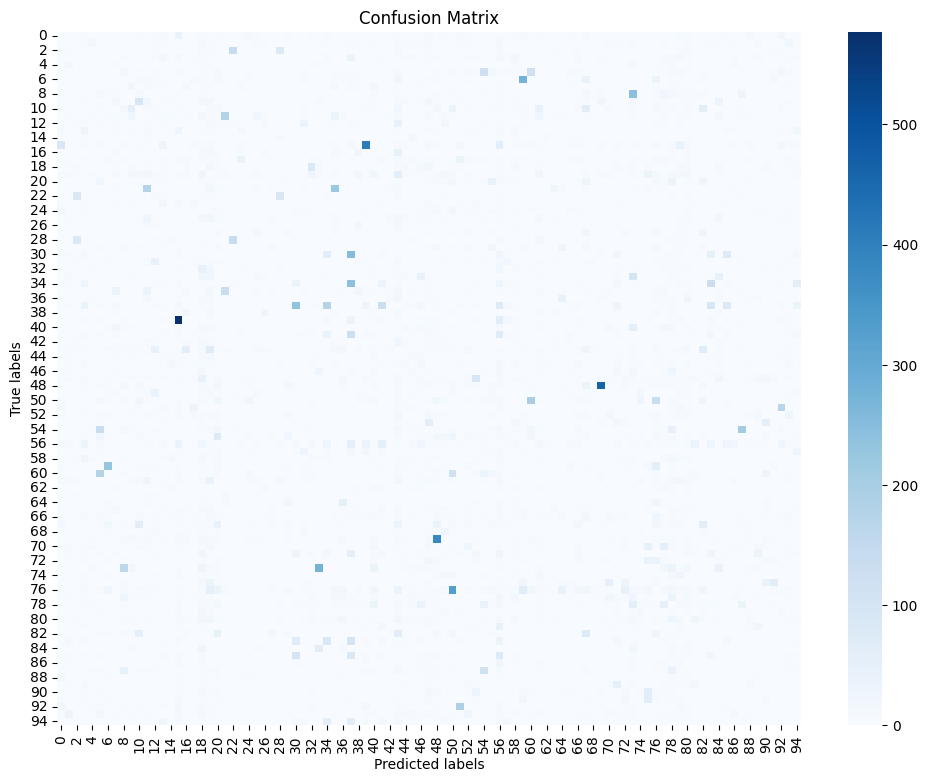

In [18]:
model_confusion_matrix = confusion_matrix(y, y_predicted)

np.fill_diagonal(model_confusion_matrix, 0)

plt.figure(figsize=(12, 9))
sns.heatmap(model_confusion_matrix, annot=False, cmap='Blues', linecolor=None)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Find the highest values and their indices
n_highest = 10  # Number of highest values to show
flat_indices = np.argsort(model_confusion_matrix.ravel())[-n_highest:]
row_indices, col_indices = np.unravel_index(flat_indices, model_confusion_matrix.shape)

print(f"Highest confusion:")
for i in range(n_highest - 1, -1, -1):  # Print in descending order
    value = model_confusion_matrix[row_indices[i], col_indices[i]] / total
    print(f"Value: {value}, Index: ({row_indices[i]}, {col_indices[i]}), Classes: ({classes[row_indices[i]]}, {classes[col_indices[i]]})")

Highest confusion:
Value: 0.0012221805649990363, Index: (39, 15), Classes: (duck, bird)
Value: 0.000978591717555554, Index: (48, 69), Classes: (feather, leaf)
Value: 0.000868447195233284, Index: (15, 39), Classes: (bird, duck)
Value: 0.0008091386062905231, Index: (69, 48), Classes: (leaf, feather)
Value: 0.0007053485756406916, Index: (76, 50), Classes: (nail, finger)
Value: 0.000584613233864357, Index: (6, 59), Classes: (axe, hammer)
Value: 0.0005782587421919184, Index: (73, 33), Classes: (moon, cookie)
Value: 0.0005337773004848478, Index: (30, 37), Classes: (cat, dog)
Value: 0.0005125956615767189, Index: (34, 37), Classes: (cow, dog)
Value: 0.0005125956615767189, Index: (8, 73), Classes: (banana, moon)


Predicted: tensor([51], device='mps:0') fish
Actual: tensor(56, device='mps:0') frog


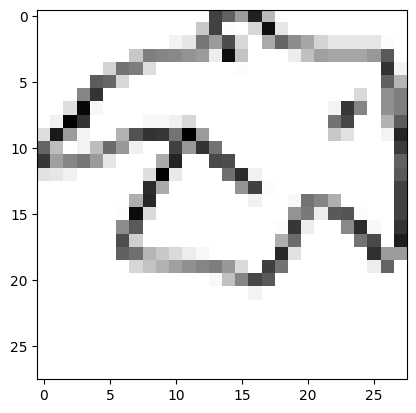

In [10]:
with torch.no_grad():  # Disable gradient calculation for inference
    for i, data in enumerate(combined_loader_test):
        images, labels = data[0].to(device), data[1].to(device)
        image = images[0]
        label = labels[0]

        predicted = torch.argmax(model(image.unsqueeze(0)), dim=1)
        print("Predicted:", predicted, classes[predicted])
        print("Actual:", label, classes[label])

        show_image(image.cpu())

        break

In [20]:
os.makedirs("models", exist_ok=True)

file_name = f"{f'{num_classes}_classes' if num_classes > 3 else '_'.join(classes)}{'_recognized' if recognized else ''}_{accuracy:.4f}_acc"

torch.save(
    {
        "model_class_name": model.__class__.__name__,
        "num_classes": num_classes,
        "state_dict": model.state_dict(),
    },
    f"models/{file_name}.pth",
)